In [ ]:
! pip install transformers

     |████████████████████████████████| 675kB 3.3MB/s 
     |████████████████████████████████| 1.1MB 21.5MB/s 
     |████████████████████████████████| 3.8MB 22.9MB/s 
     |████████████████████████████████| 890kB 35.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=77d24e89ab8605cca6c9ddae284927b64fb6ee9e0cd716c43bb87b0979b3532c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import transformers
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils import data
import torch.nn as nn
from sklearn.model_selection import train_test_split
% matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df=pd.read_csv(r'Womens Clothing E-Commerce Reviews.csv')
df['Review Text']=df['Review Text'].apply(lambda x: str(x))
df=df.head(100)


In [ ]:
df['Review Text'][0]

'Absolutely wonderful - silky and sexy and comfortable'

In [ ]:
df['Rating'].value_counts()

5    50
4    26
3    11
2     9
1     4
Name: Rating, dtype: int64

In [ ]:
def positive_negative_sentiment(x):
  if x>4:
    return 'positive'
  else:
    return 'negative'

In [ ]:
df['Sentiment']=df['Rating'].apply(lambda x: positive_negative_sentiment(x))

In [ ]:
df['Sentiment'].value_counts()

positive    50
negative    50
Name: Sentiment, dtype: int64

In [ ]:
tokenizer=transformers.BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
sample_text=df['Review Text'][0]
sample_text

'Absolutely wonderful - silky and sexy and comfortable'

In [ ]:
tokens=tokenizer.tokenize(sample_text)

In [ ]:
tokens

['Absolutely', 'wonderful', '-', 'silky', 'and', 'sexy', 'and', 'comfortable']

In [ ]:
token_ids=tokenizer.convert_tokens_to_ids(tokens)
token_ids

[24107, 7310, 118, 21453, 1105, 8141, 1105, 6062]

In [ ]:
encoding=tokenizer.encode_plus(sample_text,max_length=32,add_special_tokens=True,pad_to_max_length=True,return_attention_mask=True,return_token_type_ids=False,return_tensors='pt')
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
encoding['input_ids']

tensor([[  101, 24107,  7310,   118, 21453,  1105,  8141,  1105,  6062,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])

In [ ]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
df['Review Text'].apply(str)

0     Absolutely wonderful - silky and sexy and comf...
1     Love this dress!  it's sooo pretty.  i happene...
2     I had such high hopes for this dress and reall...
3     I love, love, love this jumpsuit. it's fun, fl...
4     This shirt is very flattering to all due to th...
                            ...                        
95    Purchased this top online, and when i received...
96    I usually wear a medium and bought a small. it...
97    I was very excited to order this top in red xs...
98                                                  nan
99    I am in need of easy comfortable tops for ever...
Name: Review Text, Length: 100, dtype: object

In [ ]:
token_lens=[]
for text in df['Review Text']:
  tokens=tokenizer.encode(str(text),max_length=512)
  token_lens.append(len(tokens))

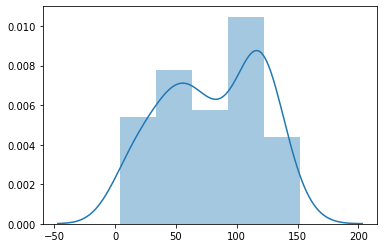

In [ ]:
sns.distplot(token_lens)

In [ ]:
encoding=tokenizer.encode_plus(sample_text,max_length=125,add_special_tokens=True,pad_to_max_length=True,return_attention_mask=True,return_token_type_ids=False,return_tensors='pt')


In [ ]:
class WReviewDataset(data.Dataset):

  def __init__(self,review,target,tokenizer,max_len):
    self.review=review
    self.target=target
    self.tokenizer=tokenizer
    self.max_len=max_len

  def __len__(self):
    return len(self.review)

  def __getitem__(self,item):
    review = self.review[item]
    target= self.target[item]

    encoding=tokenizer.encode_plus(review,max_length=self.max_len,add_special_tokens=True,pad_to_max_length=True,return_attention_mask=True,return_token_type_ids=False,return_tensors='pt')

    return {'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)}


In [ ]:
MAX_LEN=128
BATCH_SIZE=16
EPOCHS=50

In [ ]:
df_train,df_test=train_test_split(df,test_size=0.2,random_state=42)
df_val,df_test=train_test_split(df_test,test_size=0.5,random_state=42)

In [ ]:
df_train.shape, df_test.shape, df_val.shape

((80, 12), (10, 12), (10, 12))

In [ ]:
def create_data_loader(df,tokenizer,max_len,batch_size):
  ds=WReviewDataset(review=df['Review Text'].to_numpy(),
                    target=df['Sentiment'].to_numpy(),
                    tokenizer=tokenizer,
                    max_len=max_len)
  return data.DataLoader(ds,batch_size=batch_size,num_workers=4)

In [ ]:
train_data_loader= create_data_loader(df_train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader= create_data_loader(df_val,tokenizer,MAX_LEN,BATCH_SIZE)
test_data_loader= create_data_loader(df_test,tokenizer,MAX_LEN,BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff3c55c6f28>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


TypeError: ignored

In [ ]:
df['Review Text'].apply(lambda x: type(x)).value_counts()

<class 'str'>    23486
Name: Review Text, dtype: int64

In [ ]:
bert_model=transformers.BertModel.from_pretrained('bert-base-cased')

In [ ]:
last_hidden_state,pooled_output=bert_model(input_ids=encoding['input_ids'],attention_mask=encoding['attention_mask'])

In [ ]:
last_hidden_state.shape

torch.Size([1, 125, 768])

In [ ]:
pooled_output.shape

torch.Size([1, 768])

Building a Sentiment Classifier

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier,self).__init__()
    self.bert=transformers.BertModel.from_pretrained('bert-base-cased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size,n_classes)
    self.softmax = nn.Softmax(dim=1)

  def forward(self,input_ids,attention_mask):
    _, pooled_output=self.bert(input_ids=input_ids,attention_mask=attention_mask)

    output = self.drop(pooled_output)
    output = self.out(output)
    return self.softmax(output)

In [ ]:
model = SentimentClassifier(2)
model = model.to(device)

In [ ]:
input_ids= data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

